In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import subprocess

from pathlib import Path
from scipy.io import loadmat, savemat

In [20]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [3]:
import subprocess

# Define your MATLAB function's arguments
N = 2**7 + 1  # Example value; adjust as needed
dt = 1e-4  # Example value; adjust as needed
T_end = 1  # Example value; adjust as needed
mus = "0.01:0.01:0.1"  # MATLAB array syntax
Mp = 10
K = T_end / dt
DS = 1

In [4]:
import json

datapath = '/data1/jy384/research/Data/UnimodalSROB/Burgers/'
srcpath = '/home/jy384/projects/UnimodalSROB/examples/burgers/'

config = {
    "N": 2**7 + 1,
    "dt": 1e-4,
    "T_end": 1,
    "mus": "0.01:0.01:0.1",
    "Mp": 10,
    "K": 1 / 1e-4,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQIPC",
        "modeltime": "continuous",
        "dt": 1e-4,
        "ddt_order": "1ex",
        "p": 0, # polynomial order
        "lambda1": 0.1,
        "lambda2": 0.1,
        "lambda3": 0.1,
    }
}

with open(Path(srcpath) / 'config.json', 'w') as f:
    json.dump(config, f)


In [9]:
# Proper command to call your MATLAB function
matlab_cmd = (
    f"matlab -batch \"addpath('/home/jy384/projects/UnimodalSROB/examples/burgers/burgers-helpers'); "
    f"runburgers({N}, {dt}, {T_end}, [{mus}], {Mp}, {DS}); exit;\""
)

# Use subprocess to call MATLAB
subprocess.run(matlab_cmd, shell=True, check=True)

MATLAB is selecting SOFTWARE OPENGL rendering.
Running Burgers equation data generation
Parameters:
N = 129
dt = 0.0001
T_end = 1
mus = 0.01        0.02        0.03        0.04        0.05        0.06        0.07        0.08        0.09         0.1
Mp = 10
DS = 1
mu = 0.01
mu = 0.02
mu = 0.03
mu = 0.04
mu = 0.05


In [5]:
# convert mus to array of mus
mus = np.array([float(m) for m in mus.split(':')])
mus = np.arange(mus[0], mus[-1] + mus[1], mus[1])

# round mus to 2 decimal places
mus = np.round(mus, 2)

In [6]:
# check and load data
mu_start = mus[0]
mu_end = mus[-1]
mu_step = mus[1] - mus[0]

trajectories_path = Path(datapath) / 'trajectories'
snapshots_path = Path(datapath) / 'snapshots'
snapshotsDerivatives_path = Path(datapath) / 'snapshotsDerivatives'

# Find the files 
U_all_files = list(Path(datapath).rglob(f'U_all_mu_*'))
X_all_files = list(Path(datapath).rglob(f'X_all_mu_*'))
R_all_files = list(Path(datapath).rglob(f'R_all_mu_*'))

# Load the data with the mu_start, mu_end, and mu_step in their names
if U_all_files:
    for file in U_all_files:
        if str(mu_start) in file.name and str(mu_end) in file.name and str(mu_step) in file.name:
            print(file)
            U_all = loadmat(file)['U_all']
if X_all_files:
    for file in X_all_files:
        if str(mu_start) in file.name and str(mu_end) in file.name and str(mu_step) in file.name:
            print(file)
            X_all = loadmat(file)['X_all']
if R_all_files:
    for file in R_all_files:
        if str(mu_start) in file.name and str(mu_end) in file.name and str(mu_step) in file.name:
            print(file)
            R_all = loadmat(file)['R_all']

/data1/jy384/research/Data/UnimodalSROB/Burgers/trajectories/U_all_mu_0.01_0.01_0.1.mat
/data1/jy384/research/Data/UnimodalSROB/Burgers/snapshots/X_all_mu_0.01_0.01_0.1.mat
/data1/jy384/research/Data/UnimodalSROB/Burgers/snapshotsDerivatives/R_all_mu_0.01_0.01_0.1.mat


In [7]:
# Convert cell arrays to numpy arrays for X_all and R_all
X_all = np.array([X_all[0][i] for i in range(X_all.shape[1])])
R_all = np.array([R_all[0][i] for i in range(R_all.shape[1])])

print(U_all.shape, X_all.shape, R_all.shape)

(99980, 10) (10, 129, 99980) (10, 129, 99980)


# Alternating minimization to get V and Vbar

Reminder: `X` here is the snapshot matrix, `R` is the derivative matrix, `U_all` is the trajectories (i.e the domain of the function), `V` is the basis of the function, and `Vbar` is th next `q` basis functions.

In [8]:
X_all.shape

(10, 129, 99980)

In [11]:
mus = np.linspace(0.01, 0.1, 10)

## Find `r` first from relative error analysis

S =  [864.02554133 232.10969286 104.23159019  66.75624163  39.23824345]
idx =  8
rel_err_SVD[idx] =  3.5057643166247487e-06
S =  [897.81634411 212.73874802  88.45178255  58.30347723  28.06645503]
idx =  7
rel_err_SVD[idx] =  4.105894490180617e-06
S =  [930.63952173 207.58331872  83.22642885  54.50909567  24.28871264]
idx =  7
rel_err_SVD[idx] =  2.8793882312916352e-06
S =  [953.45239294 199.12069016  79.54274017  50.77702394  21.77034447]
idx =  7
rel_err_SVD[idx] =  2.2797409368058297e-06
S =  [978.04023859 192.93416073  77.17480359  47.59563193  20.0827492 ]
idx =  6
rel_err_SVD[idx] =  8.433953734510169e-06
S =  [995.96891594 186.11096461  75.62757891  44.68104865  19.1467172 ]
idx =  6
rel_err_SVD[idx] =  7.458790327929954e-06
S =  [1008.611154    178.13971756   74.03128853   42.05484446   18.16639644]
idx =  6
rel_err_SVD[idx] =  6.380647069814671e-06
S =  [1018.36664351  172.72397774   72.98196138   39.93547659   17.78126351]
idx =  6
rel_err_SVD[idx] =  5.860351382946938e-06
S =

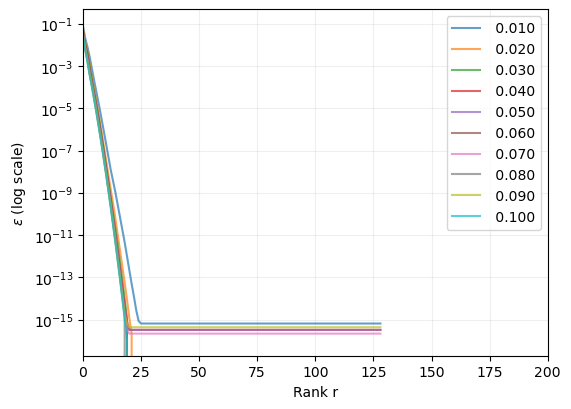

In [14]:
rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
names = [f'{mu: .3f}' for mu in mus]

fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 1e-5

for i in range(len(mus)):
    # svd
    U, S, V = np.linalg.svd(X_all[i, :, :], full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (K*Mp-1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0]
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.legend()

In [15]:
# Model parameters
p = 3           # degree of polynomial embeddings
r = np.min(idx_lst)           # number of basis vectors in Vr
q = np.max(idx_lst) - r           # number of basis vectors in Vbar
tol = 1e-3      # tolerence for alternating minimization
gamma = 0       # regularization parameter
max_iter = 100  # maximum number of iterations

In [16]:
print("r = ", r)
print("q = ", q)

r =  6
q =  2


In [23]:
Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
names = [f'{mu}' for mu in mus]

for i in range(len(mus)):
    # Procustes problem for each mu
    S = X_all[i]
    num_snapshots = S.shape[1]
    sref = np.mean(S, axis=1)
    Sref = np.array([sref,] * num_snapshots).T
    
    
    Shat, energy, Xi, Vr, Vbar, Poly = alternating_minimization(S, Sref, num_snapshots, max_iter, 1e-3, gamma, r, q, p)
    
    
    Gamma_MAM = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(S, Gamma_MAM, Sref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(Shat)
    Xi_lst.append(Xi)

***Starting alternating minimizations:
	iteration: 1	snapshot energy: 9.995462e-01	 diff: 9.995462e-01
	iteration: 2	snapshot energy: 9.995817e-01	 diff: 3.550076e-05
***Convergence criterion active!

Reconstruction error: 2.1344%
***Starting alternating minimizations:
	iteration: 1	snapshot energy: 9.998452e-01	 diff: 9.998452e-01
	iteration: 2	snapshot energy: 9.998343e-01	 diff: 1.088712e-05
***Convergence criterion active!

Reconstruction error: 1.3182%
***Starting alternating minimizations:
	iteration: 1	snapshot energy: 9.998371e-01	 diff: 9.998371e-01
	iteration: 2	snapshot energy: 9.998373e-01	 diff: 2.436715e-07
***Convergence criterion active!

Reconstruction error: 1.2796%
***Starting alternating minimizations:
	iteration: 1	snapshot energy: 9.998155e-01	 diff: 9.998155e-01
	iteration: 2	snapshot energy: 9.998276e-01	 diff: 1.212099e-05
***Convergence criterion active!

Reconstruction error: 1.3215%
***Starting alternating minimizations:
	iteration: 1	snapshot energy: 9.9980

In [ ]:
from scipy.io import savemat
# Define the file path where you want to save the data
file_path = '/home/jy384/projects/UnimodalSROB/src/BurgersOpInf_NL.mat'

# Create a dictionary to store the data
data = {
    'Vr_lst': Vr_lst,
    'Vbar_lst': Vbar_lst,
    'Shat_lst': Shat_lst,
    'proj_error_lst': proj_error_lst
}

# Save the data to the specified file path
savemat(file_path, data)


In [49]:
proj_error_lst = []

for r in range(20):
    proj_error = (1/len(mus)) * np.sum([(np.linalg.norm(X_all[i, :, :] - rob_lst[i][:, :r] @ rob_lst[i][:, :r].T @ X_all[i, :, :], ord='fro')**2)/np.linalg.norm(X_all[i, :, :], ord='fro')**2 for i in range(len(mus))])
    # proj_error = (1/len(mus)) * np.sum([(np.linalg.norm(X_all[i, :, :] - X_all[i, :, :].T @ rob_lst[i][:, r] @ rob_lst[i][:, r].T, ord='fro')**2)/np.linalg.norm(X_all[i, :, :], ord='fro')**2 for i in range(len(mus))])
    print("proj_error = ", proj_error)
    proj_error_lst.append(proj_error)
        

proj_error =  1.0
proj_error =  0.013811871146696145
proj_error =  0.0037011656429114647
proj_error =  0.0008127727164335855
proj_error =  0.0001881752319665299
proj_error =  4.288472714725449e-05
proj_error =  9.211034266722777e-06
proj_error =  1.8651332414181877e-06
proj_error =  3.5557288414229977e-07
proj_error =  6.391856136568383e-08
proj_error =  1.0877403454013046e-08
proj_error =  1.7556714685163355e-09
proj_error =  2.694952957147856e-10
proj_error =  3.945034501146514e-11
proj_error =  5.5053876153095166e-12
proj_error =  7.325157029036822e-13
proj_error =  9.281348870393531e-14
proj_error =  1.1165081323799404e-14
proj_error =  1.2717669501516708e-15
proj_error =  1.3673255260485358e-16


idx =  6


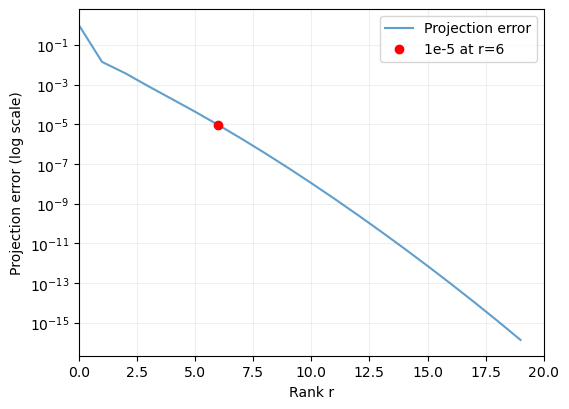

In [34]:
# plot the projection error
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(proj_error_lst, label="Projection error", linestyle='-', alpha=0.7)

# plot the first idx when it is less than 1e-5
idx = np.where(np.array(proj_error_lst) < 1e-5)[0][0]
print("idx = ", idx)
ax.plot(idx, proj_error_lst[idx], 'ro', label=f"1e-5 at r={idx}")

ax.set_yscale('log')
ax.set_ylabel("Projection error (log scale)")
# set limit
ax.set_xlim([0, 20])
# ax.set_ylim([1e-13, 1e-3])
# show grid
ax.grid(True, alpha=0.2)
ax.set_xlabel("Rank r")
ax.legend()
plt.show()

# Define truncation order r

In [35]:
r = np.max(idx_lst)
print("r = ", r)

print("Shape of the robs = ", np.array(rob_lst).shape)

r =  6
Shape of the robs =  (10, 129, 129)


# Get the ROBs and save them for matlab OpInf routine

In [38]:
# rob_lst = np.array(rob_lst)
# print("rob_lst = ", rob_lst.shape)

# truncation of the ROBs
# rob_lst = rob_lst[:, :, :r]
# print("truncated rob_lst = ", rob_lst.shape)

# # make it a suitable shape for matlab routine, where ROBs are stored in the third dimension
# rob_lst = np.moveaxis(rob_lst, 0, 2)
# print("rob_lst = ", rob_lst.shape)

rob_arr = []

for i in range(len(mus)):
    rob_arr.append(rob_lst[i][:, :r])
    
rob_arr = np.array(rob_arr)
print("rob_arr = ", rob_arr.shape)

rob_arr = np.transpose(rob_arr, (1, 2, 0))
print("rob_arr = ", rob_arr.shape)
    

rob_arr =  (10, 129, 6)
rob_arr =  (129, 6, 10)


In [39]:
# save the ROBs as Vr_all.mat at datapath
# savemat(f'{datapath}/Vr_all.mat', {'Vr_all': rob_lst})
savemat(f'{datapath}/Vr_all.mat', {'Vr_all': rob_arr})

# Matlab routine for OpInf

In [40]:
# params.modelform = 'LQI';           % model is linear-quadratic with input term
# params.modeltime = 'continuous';    % learn time-continuous model
# params.dt        = dt;              % timestep to compute state time deriv
# params.ddt_order = '1ex';           % explicit 1st order timestep scheme

# % Inputs:
# %   - params: parameters for the operator inference, including:
# %       - modelform: model form of the operator
# %       - modeltime: model time of the operator
# %       - dt: timestep to compute state time derivative
# %       - ddt_order: explicit 1st order timestep scheme
# %   - mus: parameter values
# %   - r: POD basis order
# %   - X_all: state data
# %   - R_all: RHS data (residual)
# %   - U_all: input data
# %   - Vr_all: truncated POD basis


# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

with open(Path(srcpath) / 'config.json', 'w') as f:
    json.dump(config, f)



matlab_opinf_cmd = (
    f"matlab -batch \"addpath('/home/jy384/projects/UnimodalSROB/examples/burgers/'); "
    f"run_burgersOpInf; exit;\""
)

# Use subprocess to call MATLAB
subprocess.run(matlab_opinf_cmd, shell=True, check=True)

MATLAB is selecting SOFTWARE OPENGL rendering.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
Operators are stable. Storing operators.
> In semiImplicitEuler (line 14)
  In run_burgersOpInf (line 73) 
> In semiImplicitEuler (line 14)
  In run_burgersOpInf (line 73) 
> In semiImplicitEuler (line 14)
  In run_burgersOpInf (line 73) 
> In semiImplicitEuler (line 14)
  In run_burgersOpInf (line 73) 
> In semiImplicitEuler (line 14)
  In run_burgersOpInf (line 73) 
> In semiImplicitEuler (line 14)
  In run_burgersOpInf (line 73) 


CompletedProcess(args='matlab -batch "addpath(\'/home/jy384/projects/UnimodalSROB/examples/burgers/\'); run_burgersOpInf; exit;"', returncode=0)

In [60]:
# Read s_ref_all.mat and s_rec_all.mat
s_ref_all = loadmat(f'{datapath}/s_ref_all.mat')['s_ref_all']
s_rec_all = loadmat(f'{datapath}/s_rec_all.mat')['s_rec_all']

# extract the tensors from the cell arrays
s_ref_all = np.array([s_ref_all[i][0] for i in range(s_ref_all.shape[0])])
s_rec_all = np.array([s_rec_all[i][0] for i in range(s_rec_all.shape[0])])

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


/tmp/ipykernel_3828844/1800387439.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


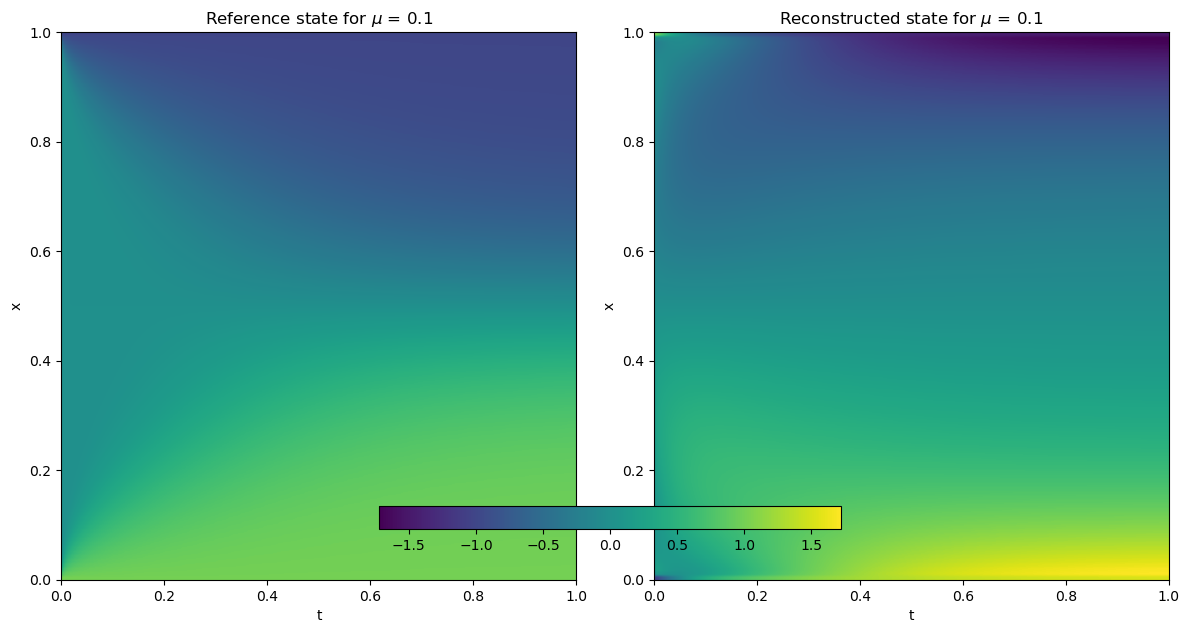

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


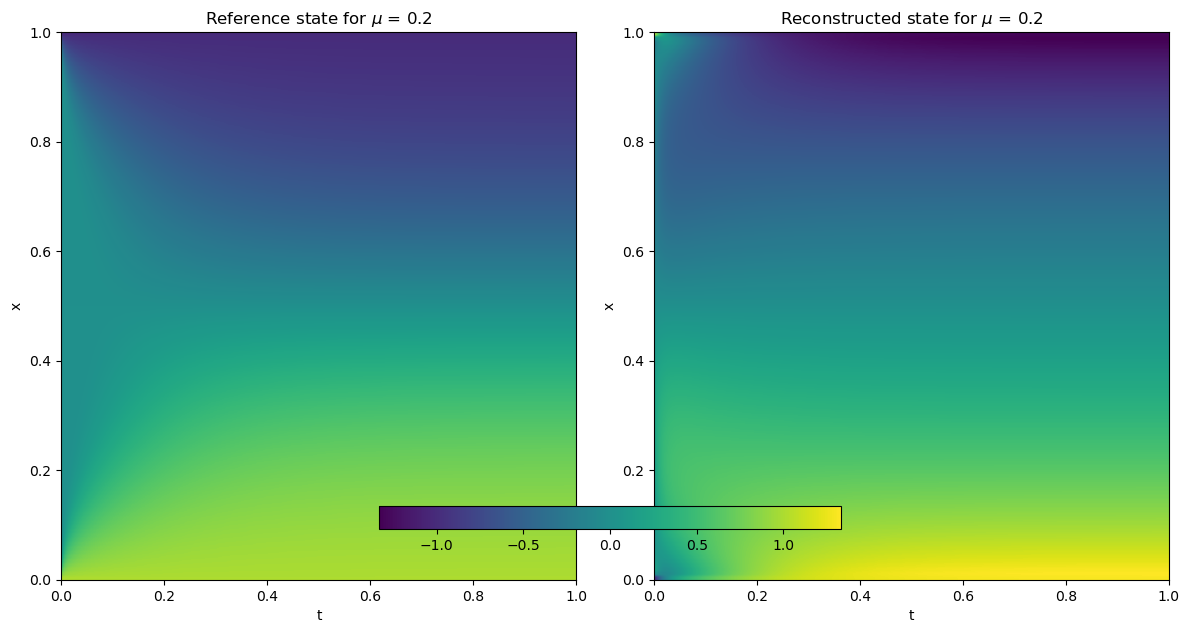

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


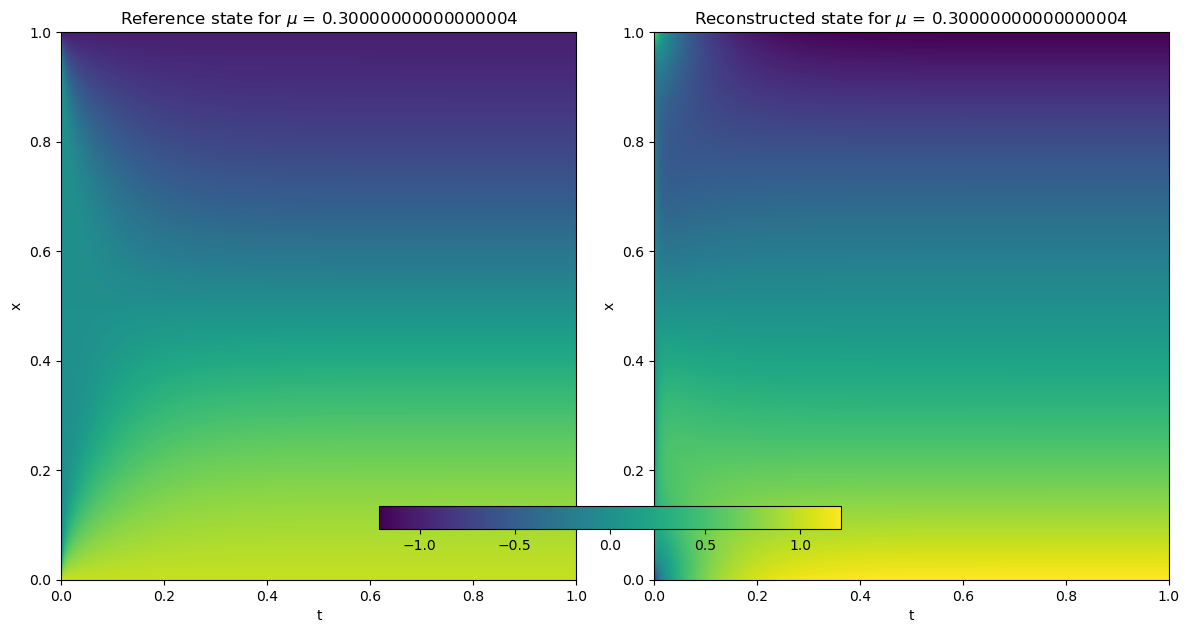

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


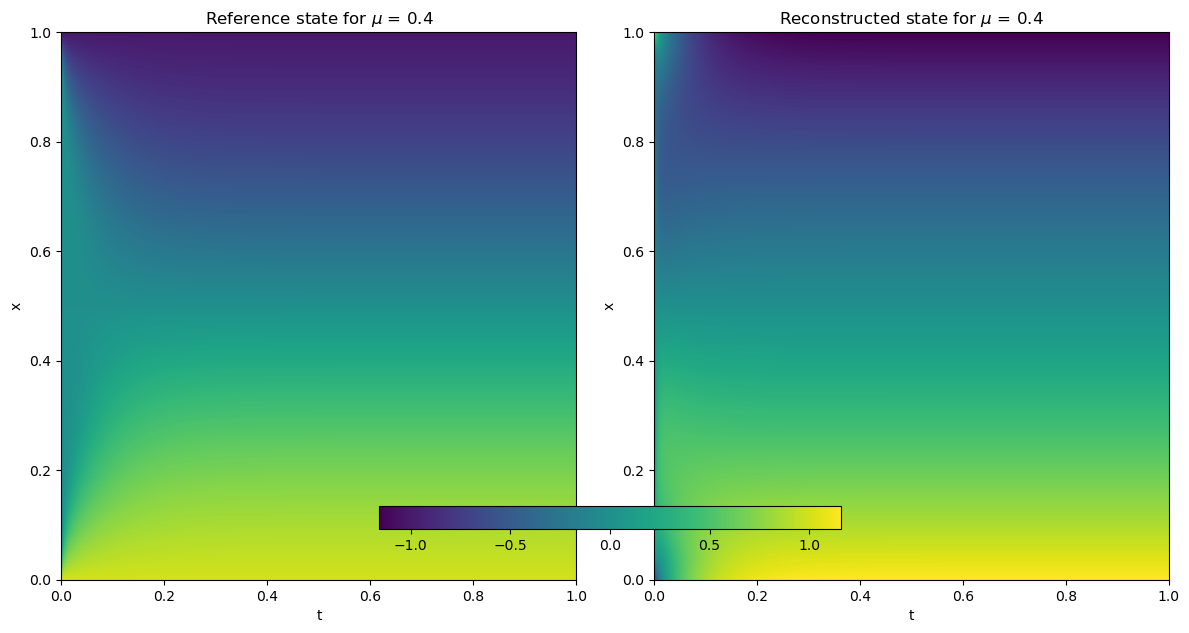

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


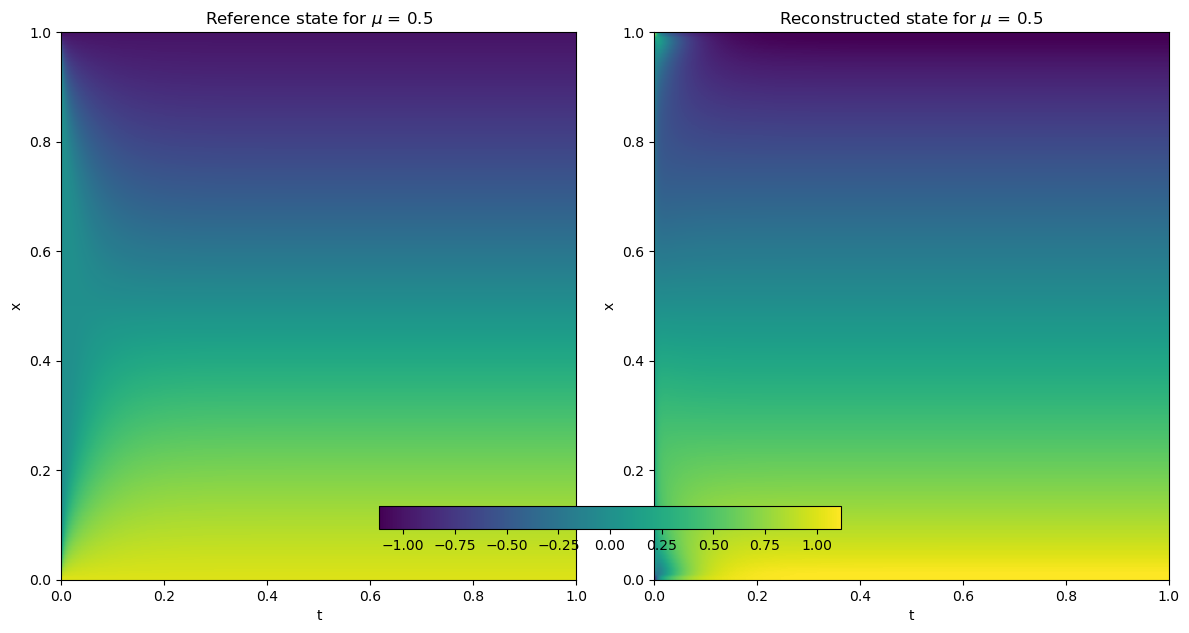

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


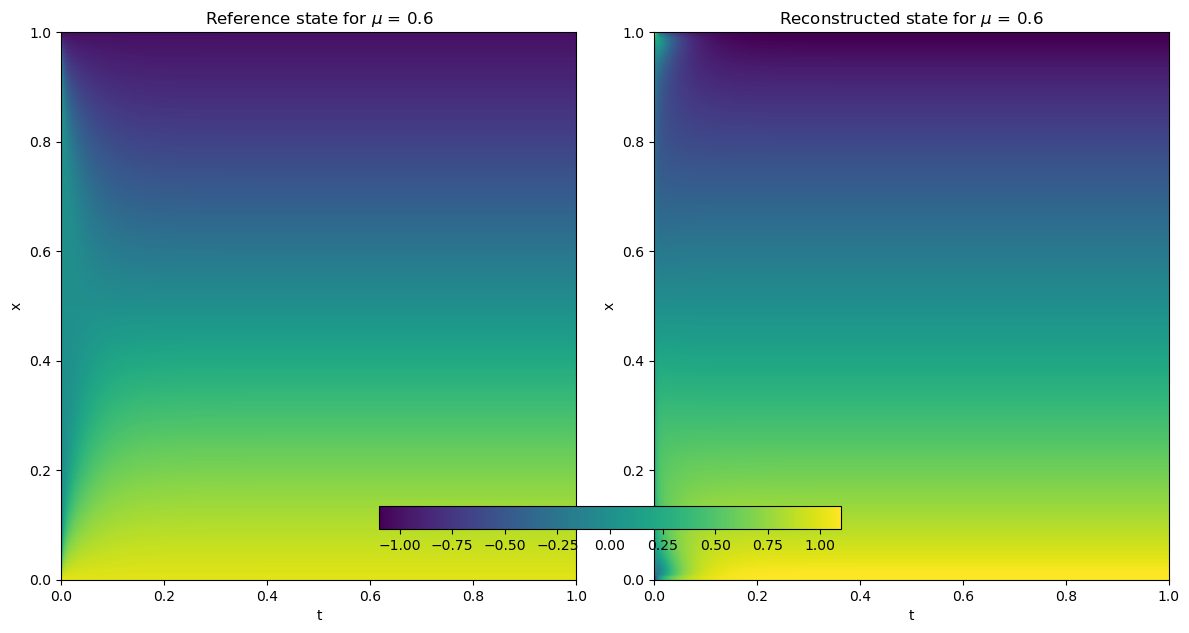

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


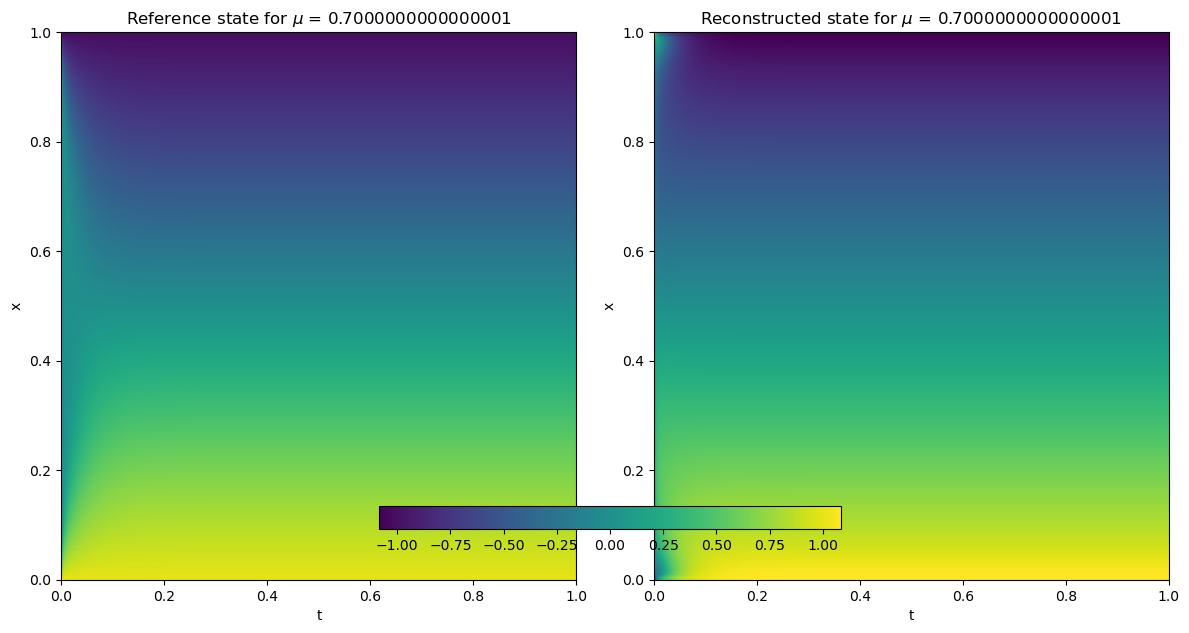

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


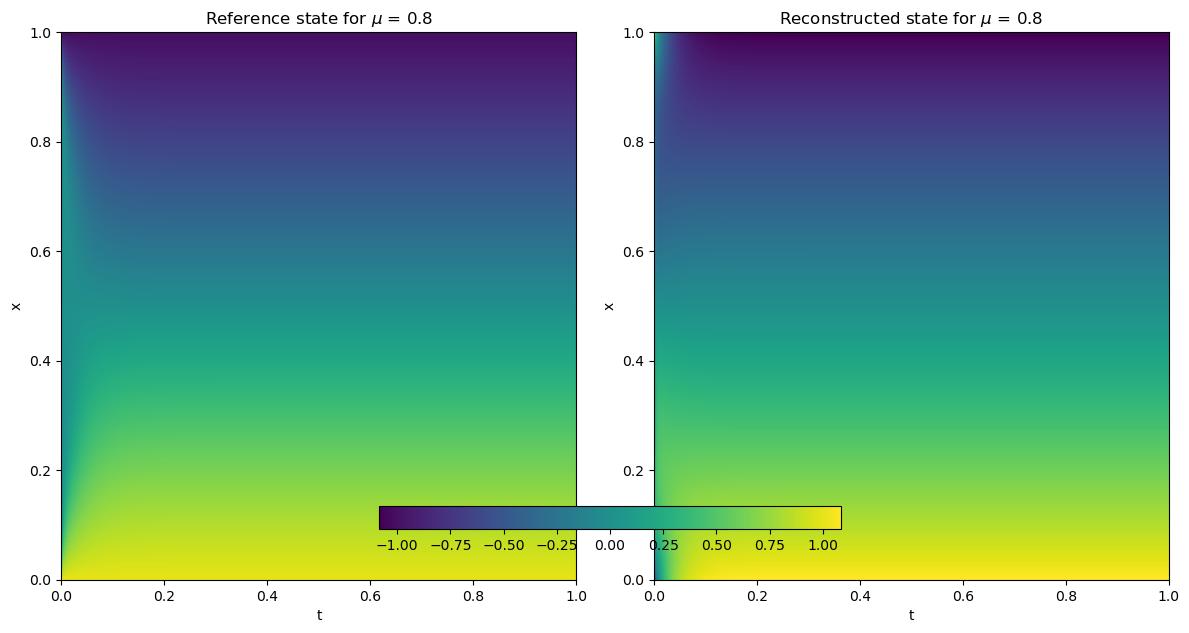

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


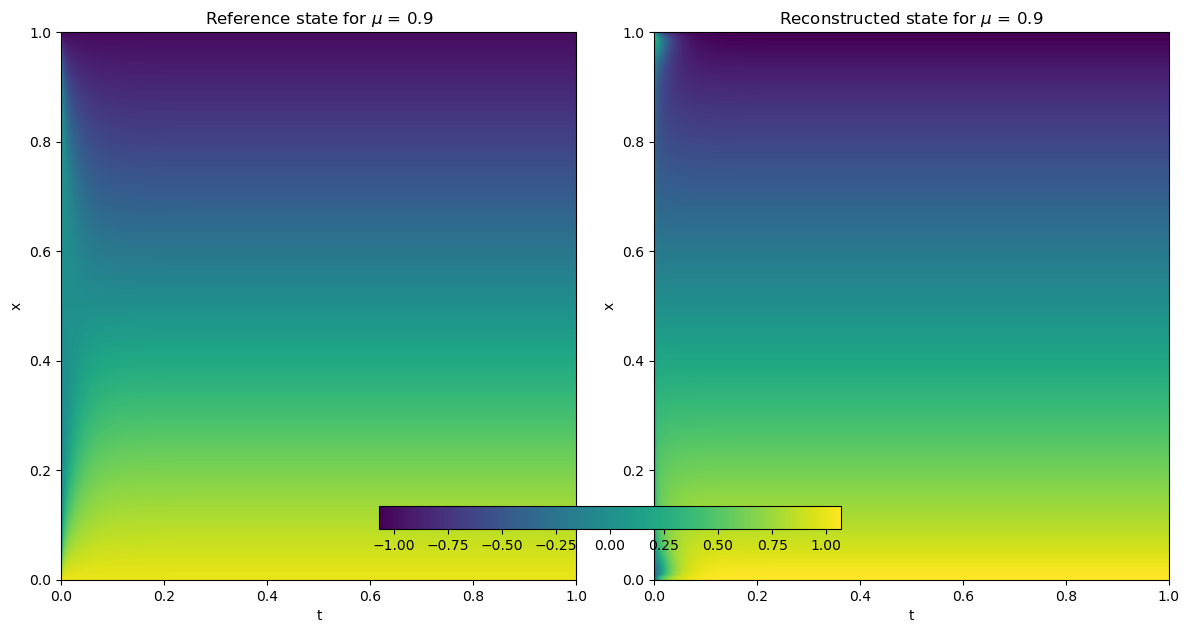

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


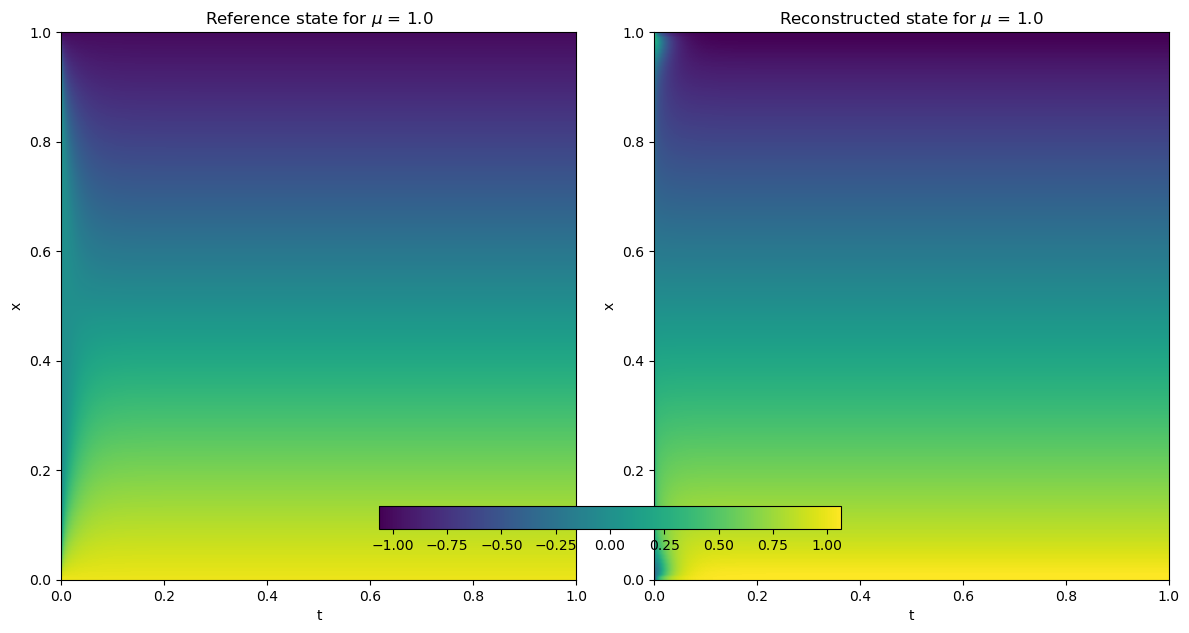

In [63]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(Mp):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    X, Y = np.meshgrid(np.linspace(0.0, T_end, int(K+1)), np.linspace(0.0, 1.0, N))
    print("X = ", X.shape)
    print("Y = ", Y.shape)
    print("s_ref_all[i] = ", s_ref_all[i].shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs[0].imshow(s_ref_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'Reference state for $\mu$ = {mus[i]}')
    
    c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Reconstructed state for $\mu$ = {mus[i]}')  
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    vmin = np.min([np.min(s_ref_all[i]), np.min(s_rec_all[i])])
    vmax = np.max([np.max(s_ref_all[i]), np.max(s_rec_all[i])])
    c1.set_clim(vmin=vmin, vmax=vmax)
    c2.set_clim(vmin=vmin, vmax=vmax)
    
    fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()